In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [119]:
df = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

In [120]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [122]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

There are no missing values and all the variables are numerical.

In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


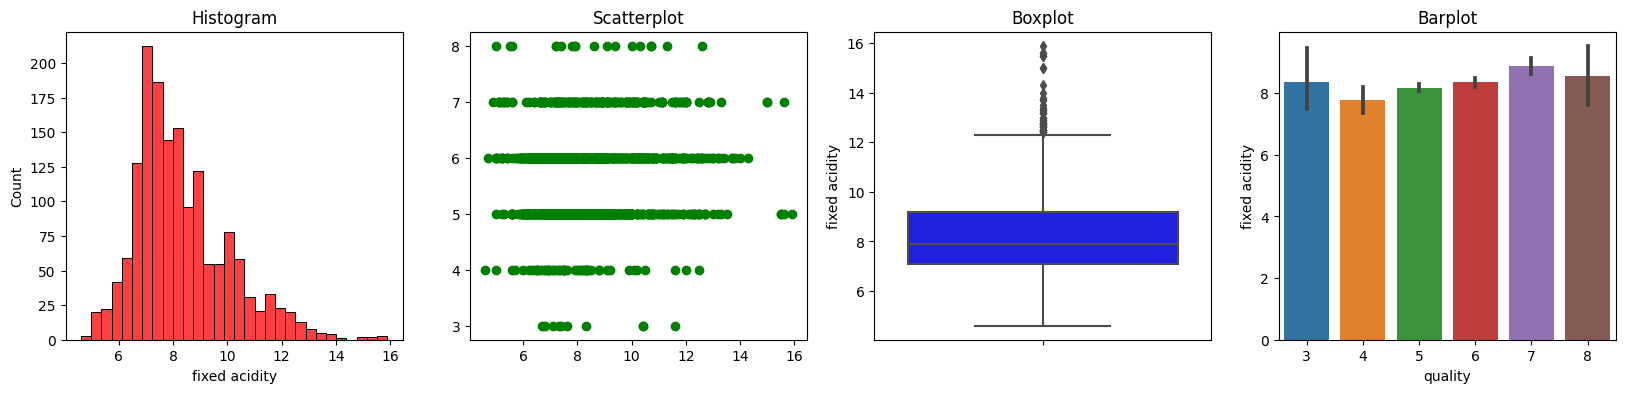

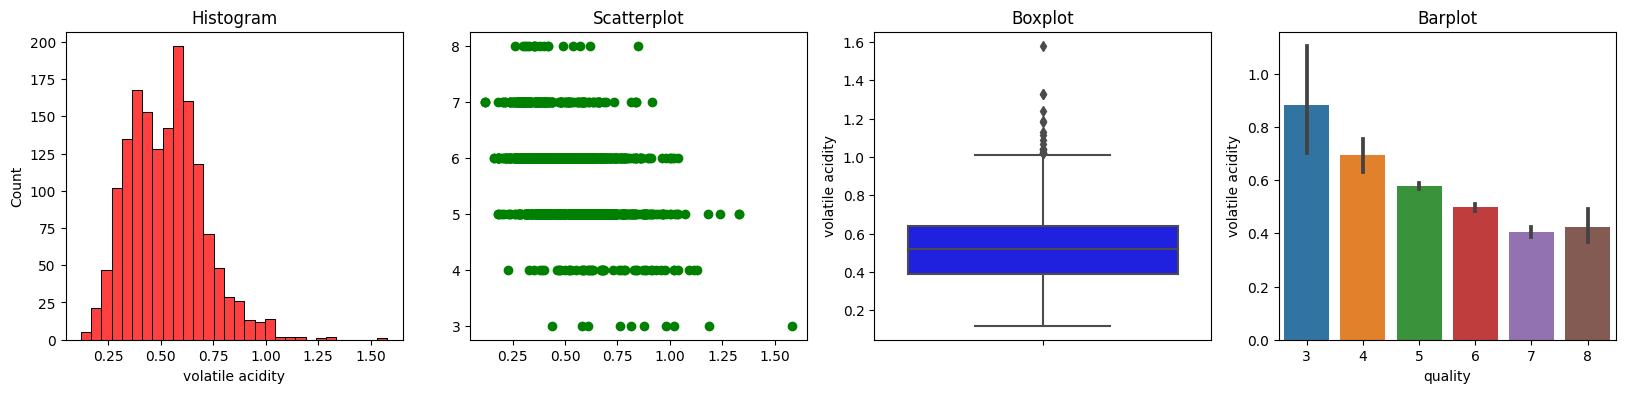

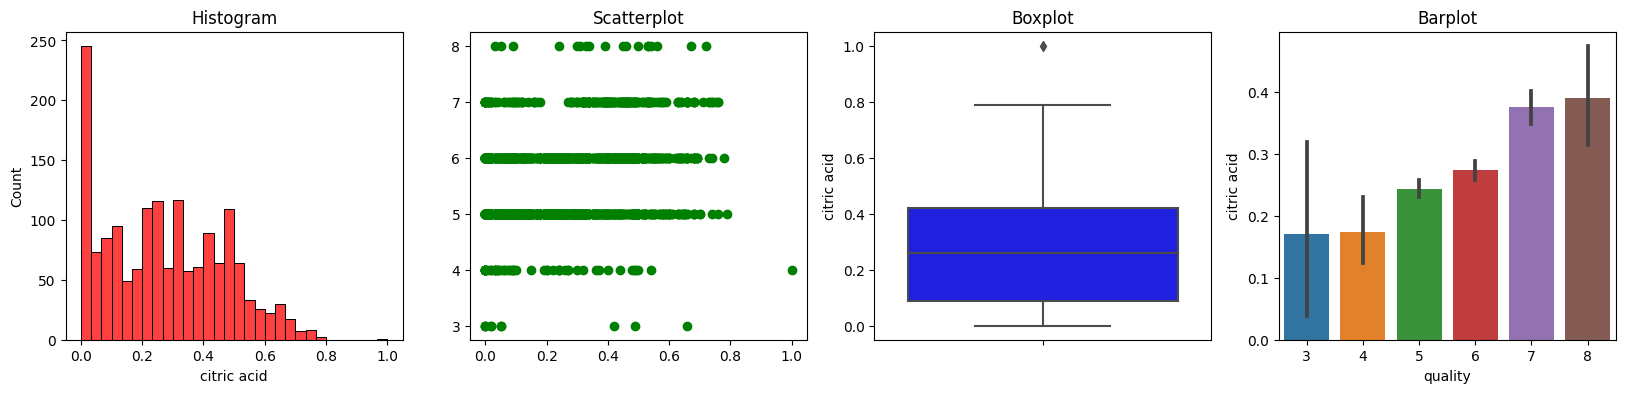

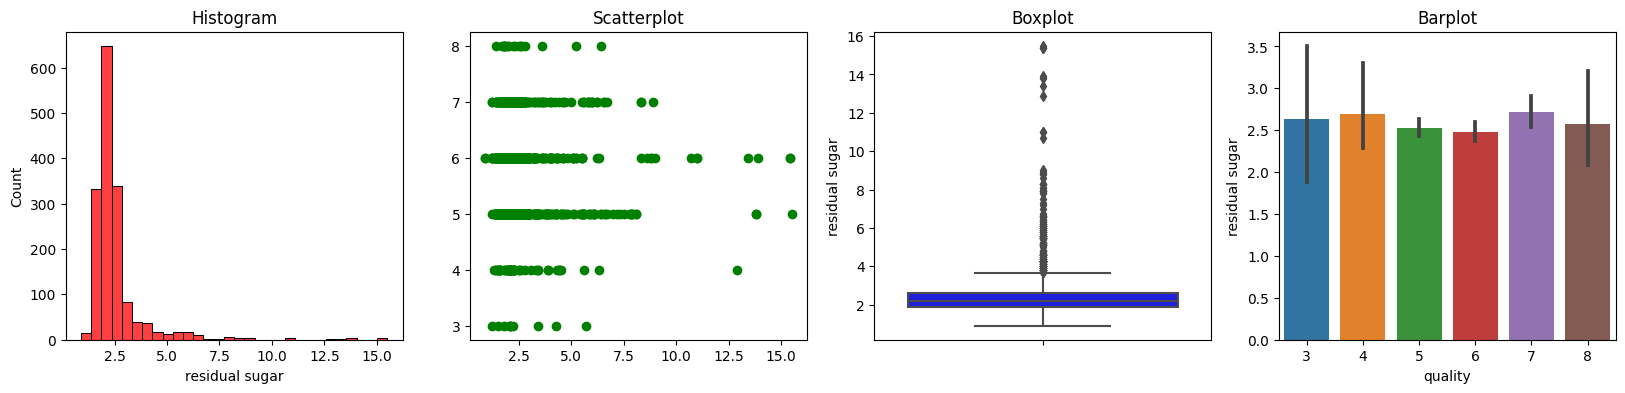

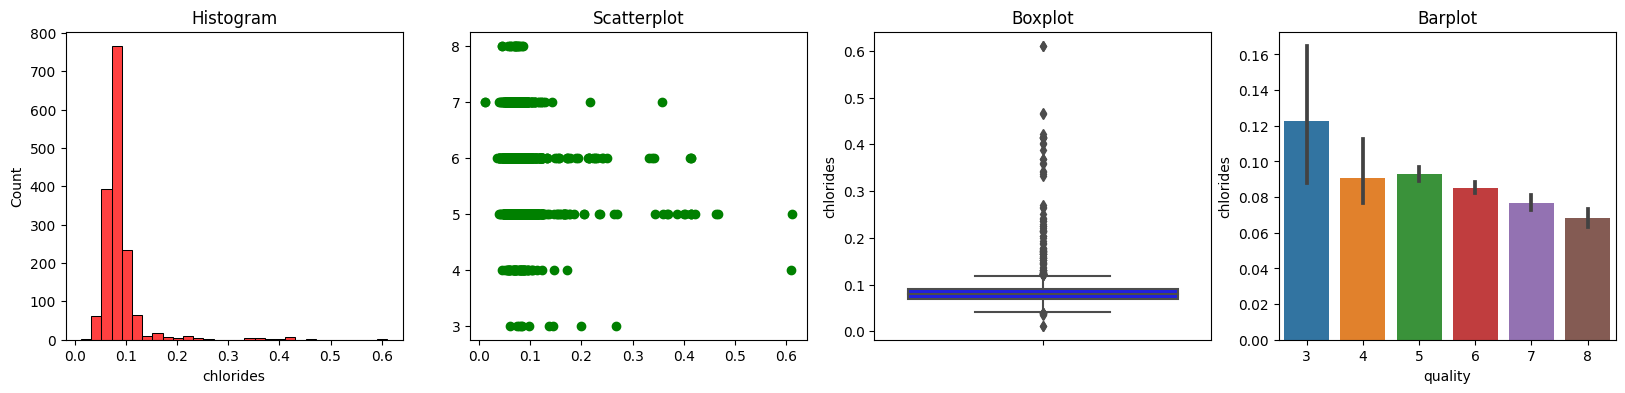

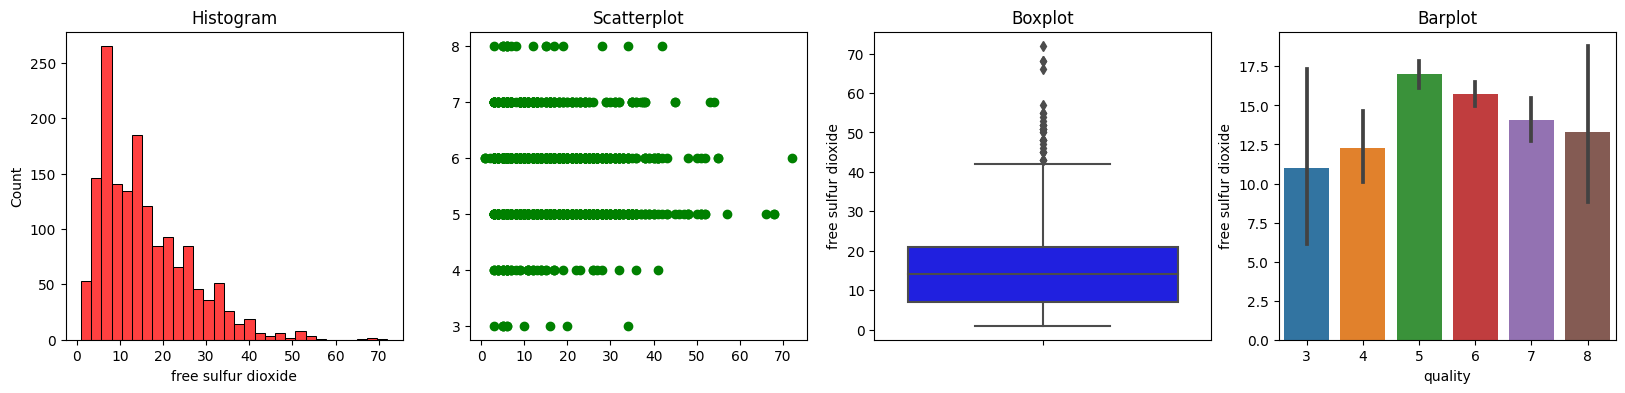

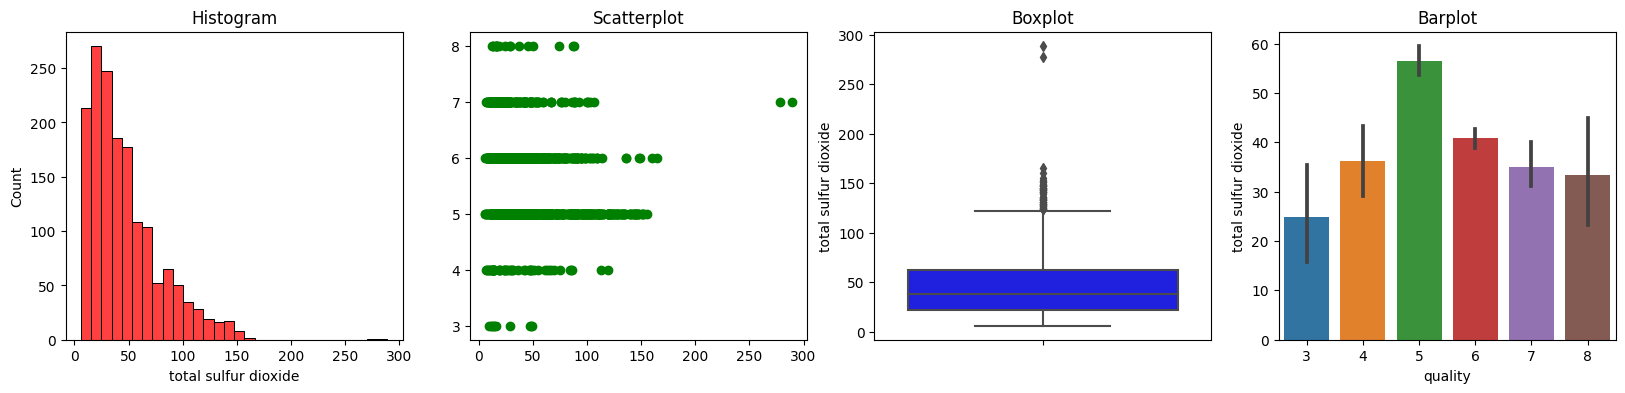

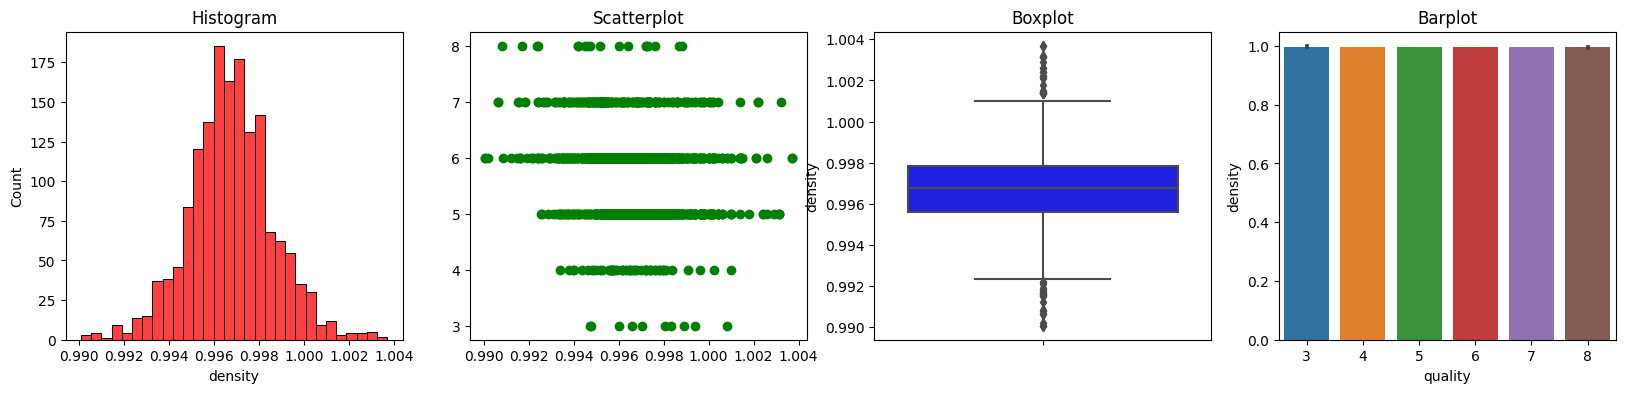

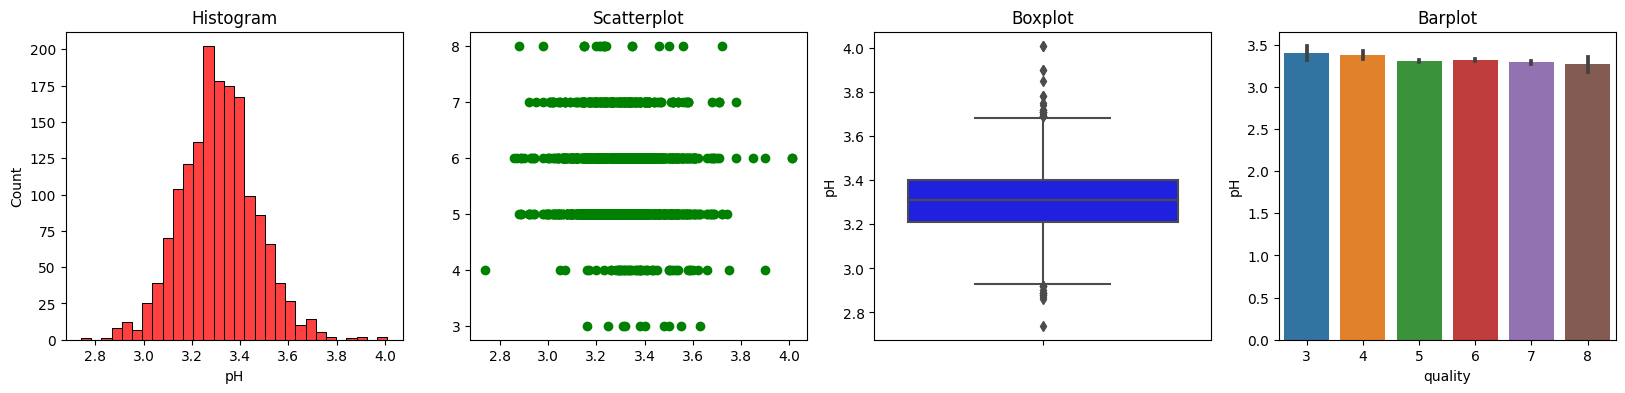

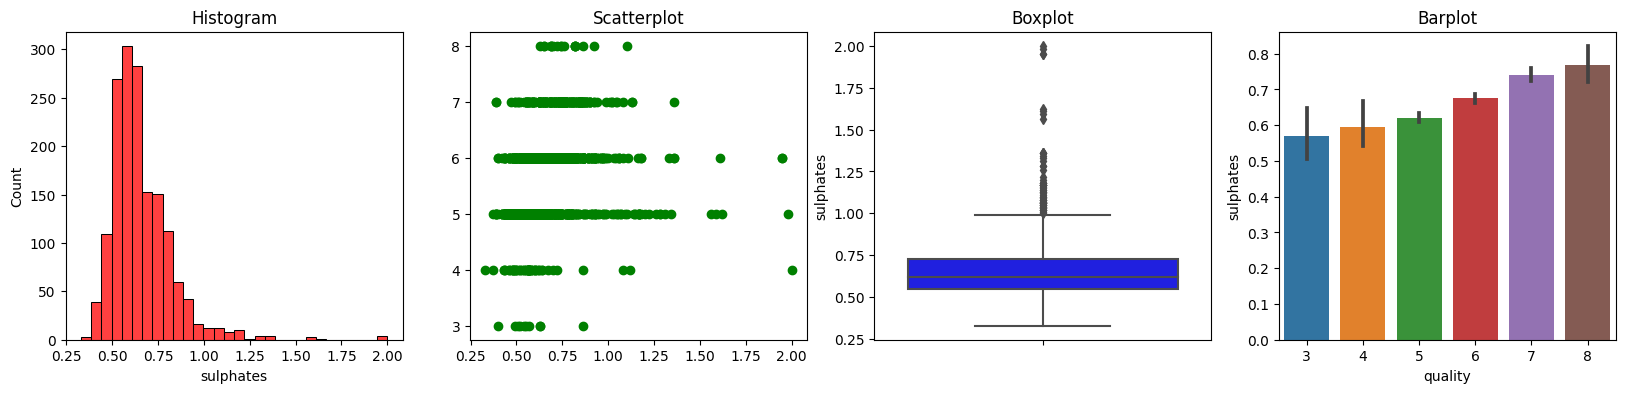

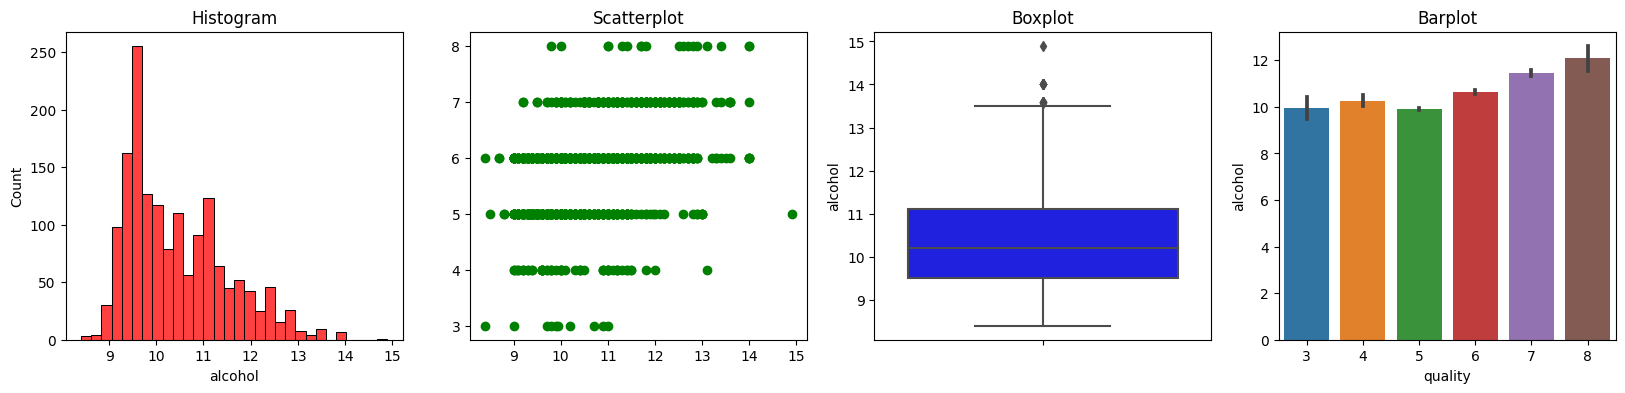

In [124]:
# Function to create a histogram, scatterplot, boxplot and a barplot.
def diagnostic_plots(df, variable, target):

    plt.figure(figsize=(20, 4))

    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30, color = 'r')
    plt.title('Histogram')

    plt.subplot(1, 4, 2)
    plt.scatter(df[variable], df[target], color = 'g')
    plt.title('Scatterplot')
    
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable], color = 'b')
    plt.title('Boxplot')
    
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    plt.show()

for variable in df.drop(columns=['quality']):
   diagnostic_plots(df, variable, 'quality')

We can see multiple features with skewed distribution and outliers. Therefore, we will remove outliers with Z-score over 3 and use the Box-Cox tranformation to stabilize the variance and make the data more normally distributed.

<Axes: >

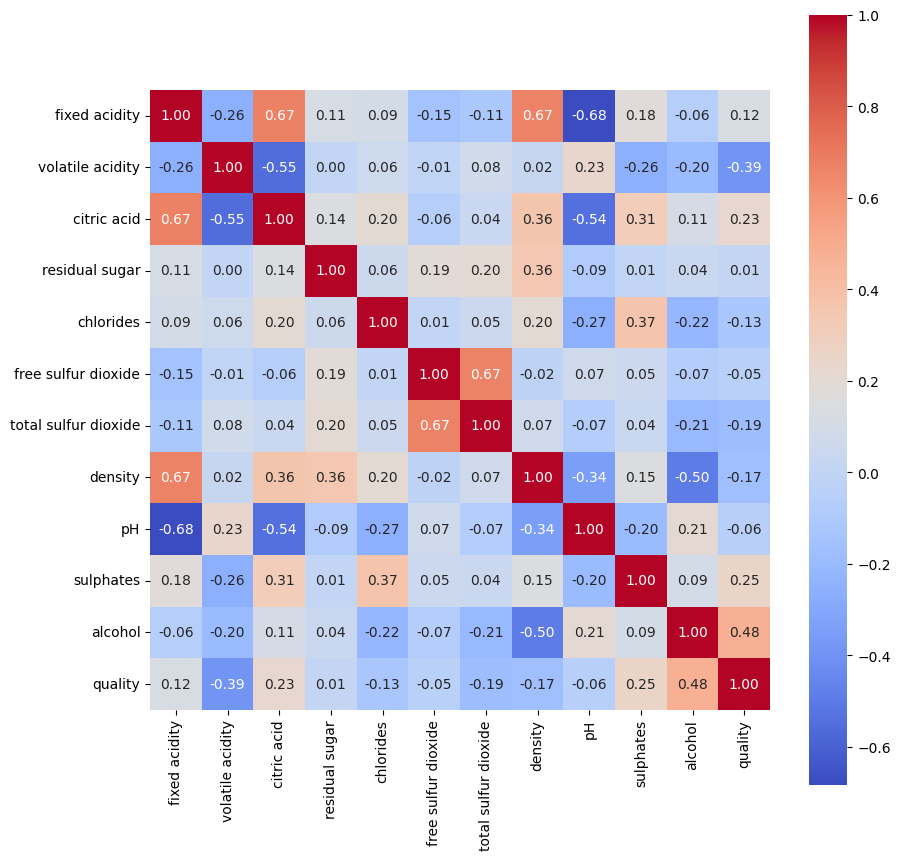

In [125]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt = '.2f', annot = True, annot_kws={'size':10}, cmap = 'coolwarm')

We can also see multicollinearity between the features. Therefore, we will apply the Principal Component Analysis (PCA) to simplify our dataset by reducing dimensionality.

<Axes: xlabel='quality', ylabel='count'>

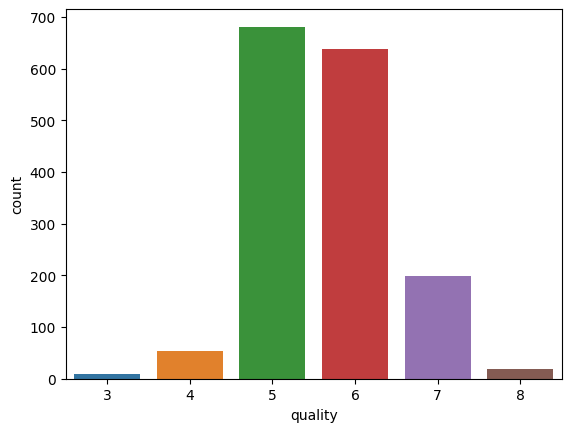

In [126]:
sns.countplot(df, x='quality')

We can see the quality score assigned to the wines is from 3 to 8, but the classes at the edge of the range have low representation. Therefore, we will divide the target variable into 3 classes.

In [127]:
df['quality'] = df['quality'].apply(lambda x: 0 if x in [3, 4] else (1 if x in [5, 6] else 2))

In [128]:
# Remove outliers based on Z-score
threshold = 3

# Compute Z-scores for each column
z_scores = ((df - df.mean()) / df.std()).abs()
    
# Find rows with any Z-score greater than the threshold
outlier_mask = z_scores.apply(lambda row: any(row > threshold), axis=1)
    
# Remove rows containing outliers
df = df[~outlier_mask]

In [129]:
X = df.drop(columns=['quality'])
y = df['quality']

In [130]:
# Apply Box-Cox transformation and return transformed values and lambda parameter
for feature in X:
    X[feature], _ = boxcox(X[feature] + 1)  # Adding 1 to handle zero values

In [131]:
# Standardize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Determine the number of principal components to retain
n_components = len(cumulative_explained_variance_ratio[cumulative_explained_variance_ratio <= 0.95])

# Re-fit PCA with the determined number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame to store the principal components
pc_names = [f"PC{i+1}" for i in range(n_components)]
pc_df = pd.DataFrame(data=X_pca, columns=pc_names)

# Concatenate the principal components with the target variable 'quality'
final_df = pd.concat([pc_df, df['quality']], axis=1)
df = final_df.dropna()

In [132]:
model_names, predictions, cv_scores, tts_scores = [], [], [], []

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [134]:
# LogisticRegression()
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

predictions.append(pred)
cv = cross_val_score(lr, X, y, cv=5)
model_names.append("Logistic Regression (multinomial)")
cv_scores.append(str(round(cv.mean()*100, 2)) + " %")
tts_scores.append(str(round(accuracy_score(y_test, pred)*100, 2)) + " %")

In [135]:
# RandomForestClassifier()
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
pred = rf_classifier.predict(X_test)

predictions.append(pred)
cv = cross_val_score(rf_classifier, X, y, cv=5)
model_names.append("Random Forest Classifier")
cv_scores.append(str(round(cv.mean()*100, 2)) + " %")
tts_scores.append(str(round(accuracy_score(y_test, pred)*100, 2)) + " %")

In [136]:
# Support Vector Machines (SVMs)
svm_classifier = SVC(kernel='linear', C=1.0, gamma='scale')
svm_classifier.fit(X_train, y_train)
pred = svm_classifier.predict(X_test)

predictions.append(pred)
cv = cross_val_score(svm_classifier, X, y, cv=5)
model_names.append("Support Vector Machines (linear)")
cv_scores.append(str(round(cv.mean()*100, 2)) + " %")
tts_scores.append(str(round(accuracy_score(y_test, pred)*100, 2)) + " %")

In [137]:
model_acc_cv_df = pd.DataFrame(list(zip(model_names,tts_scores,cv_scores)), columns=["Model", "Accuracy Score", "CV Score"])
model_acc_cv_df.index = np.arange(1, len(model_acc_cv_df)+1)
print(model_acc_cv_df)

                               Model Accuracy Score CV Score
1  Logistic Regression (multinomial)        82.19 %  81.89 %
2           Random Forest Classifier        86.99 %  83.68 %
3   Support Vector Machines (linear)        82.53 %  82.51 %


All 3 models have accuracy above 80%, while the RFC seems to be slightly more precise. Let's see also the confusion matrix to better understand the errors.

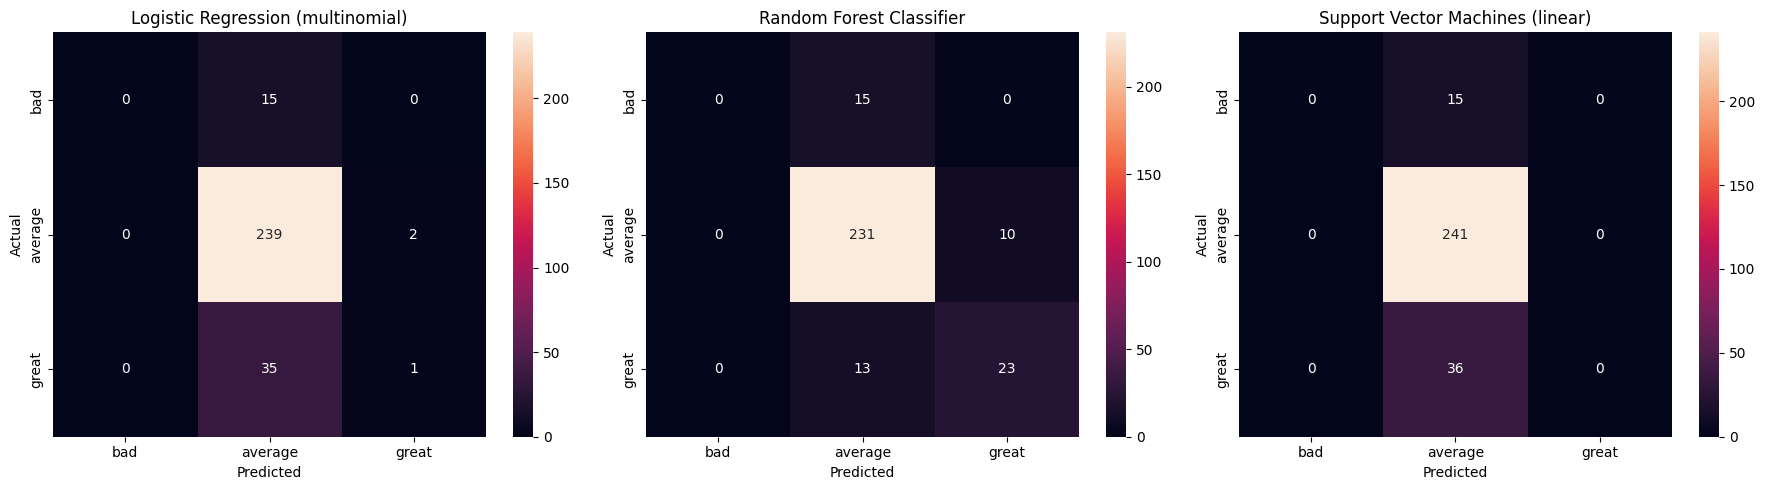

In [138]:
labels=['bad', 'average', 'great']
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, y_pred) in enumerate(zip(model_names, predictions)):
    plt.subplot(1, len(model_names), i+1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(model_name)

plt.tight_layout()
plt.show()